# Natural Language Processing with Disaster Tweets
# Ali Alsinan

## 1.Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they are observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it is not always clear whether a person's words are actually announcing a disaster. In this competition, we are challenged to build a machine learning model that predicts which Tweets are about real disasters and which one's are not.

## 2.Data Overview

In [3]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Natual Language Processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [4]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")
train= train_df.copy()

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Distribution of target
print(f"Number of observations in training: {train_df.shape[0]}")
print(f"Number of categories in target: {train_df['target'].nunique()}")
print(f"Number of observations in testing: {test_df.shape[0]}")

Number of observations in training: 7613
Number of categories in target: 2
Number of observations in testing: 3263


The dataset consists of a total of 10,876 observations, divided into a training set and a testing set. The training set includes 7,613 observations, while the testing set comprises 3,263 observations. The target variable in this dataset is categorical, with two distinct categories or classes.

1 represent disaster tweet

0 represent non disaster tweet

#### Target distribution
The target class distribution in this dataset shows that class 0 has 4,342 instances, while class 1 has 3,271 instances. This results in a class balance where class 0 constitutes approximately 57% of the data, and class 1 represents around 43%. Although the dataset is not perfectly balanced, the imbalance is not severe. Depending on the model's sensitivity to class imbalance, techniques such as class weighting or resampling could be considered to ensure balanced performance across both classes, though they may not be strictly necessary given the relatively modest imbalance.

The count of class 1 is 3271
The count of class 0 is 4342


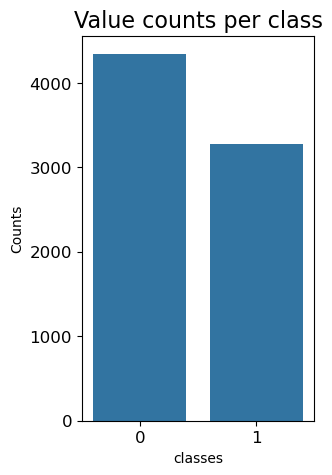

In [10]:
# Value counts per category
trainCat = train_df.target.value_counts()

fig, axis = plt.subplots(1, 1, figsize=(3,5))
graph = sns.barplot(x=trainCat.index, y=trainCat)
t = graph.set_title("Value counts per class",fontsize=16)
t = plt.xlabel('classes')
t = plt.ylabel('Counts')
plt.tick_params(labelsize = 12)

print(f'The count of class 1 is',(train_df.target == 1).sum())
print(f'The count of class 0 is',(train_df.target == 0).sum())

<Axes: xlabel='target', ylabel='NumberOfWords'>

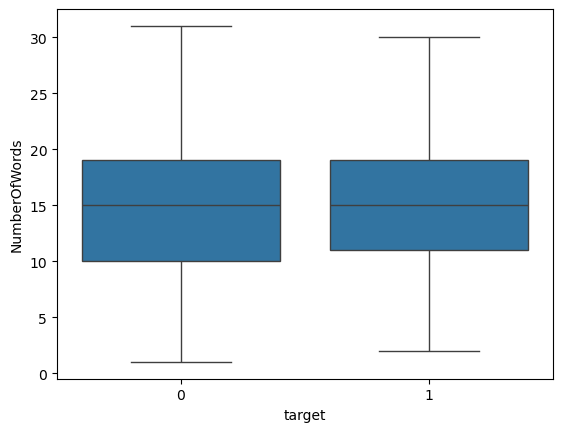

In [11]:
train_num = train_df.copy()
train_num['NumberOfWords'] = train['text'].str.split().apply(len)
sns.boxplot(data=train_num,
            x='target',
            y='NumberOfWords')

The box plot analysis reveals that there are no outliers present in the dataset.

### Preprocessing : Removing URL, punctuations, and stopwords
removing URLs and punctuation, both common steps for preparing text in natural language processing (NLP) tasks. The remove_URL function uses a regular expression to identify and remove URLs by matching any string that starts with "http" or "www" and continues until a space or end of the line, effectively cleaning web links that are usually irrelevant for text analysis. Meanwhile, the remove_punct function removes punctuation characters using string.punctuation, which contains common punctuation symbols. A translation table created with str.maketrans('', '', string.punctuation) maps each punctuation character to None, and the translate method then removes these characters from the text. By removing URLs and punctuation, this code reduces noise, allowing models to focus on meaningful words and phrases in the text.

#### Removing URL & Punctuations

In [15]:
# Preprocessing
import re
import string
# Remove URL from the text
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Remove puctuations
def remove_punct(text):
    translator = str.maketrans('', '', string.punctuation) # Create a translation table to delete all punctuation
    return text.translate(translator) # Use this translation table to transform the text by removing punctuation characters

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
pattern = re.compile(r'https?://(\S+|www)\.\S+')
for t in train_df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r'', t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [17]:
# Apply the functions
train_df['text'] = train_df.text.map(remove_URL) # map(lambda x : remove_URL(x))
train_df['text'] = train_df.text.map(remove_punct)

In [18]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


#### Removing stopwords
The stopwords.words('english') set is used to create a collection of common words that typically add little value in NLP tasks. In the remove_stopwords function, the input text is split into individual words, and a list comprehension filters out any word that appears in the stopwords list. The remaining words are then joined into a single, filtered string. By removing stopwords, this function simplifies the text, allowing NLP models to focus on more meaningful terms that contribute to the text’s overall content and context.

In [20]:
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
  filtered_words = [word for word in text.split() if word not in stopwords.words('english')]
  return ' '.join(filtered_words)

In [21]:
# 10 exapmles of stopwords
import random
random.sample(list(stop), 10)

["that'll",
 'before',
 'then',
 'most',
 'against',
 'than',
 "couldn't",
 'few',
 'theirs',
 "mightn't"]

In [22]:
# The length of text
text_length = train_df['text'].str.len()
text_length.describe()

count    7613.000000
mean       83.591226
std        31.460470
min         6.000000
25%        60.000000
50%        85.000000
75%       109.000000
max       145.000000
Name: text, dtype: float64

In [23]:
# Apply the function
train_df['text'] = train_df['text'].map(remove_stopwords)
train_df.text

0        Our Deeds Reason earthquake May ALLAH Forgive us
1                   Forest fire near La Ronge Sask Canada
2       All residents asked shelter place notified off...
3       13000 people receive wildfires evacuation orde...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant cranes holding bridge collapse nearb...
7609    ariaahrary TheTawniest The control wild fires ...
7610                    M194 0104 UTC5km S Volcano Hawaii
7611    Police investigating ebike collided car Little...
7612    The Latest More Homes Razed Northern Californi...
Name: text, Length: 7613, dtype: object

#### Count the number of unique words

In [25]:
# Count unique words
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

In [26]:
# The number of unique words
counter = counter_word(train_df.text)
num_unique_words = len(counter)
num_unique_words

22093

In [27]:
counter.most_common(5)

[('I', 1225), ('The', 581), ('like', 321), ('A', 302), ('amp', 298)]

## 3.Tokenize the text data
Tokenizing text data is a fundamental step in natural language processing (NLP) where text is split into smaller units, called tokens. Tokens can be words, subwords, sentences, or even characters, depending on the analysis goals. By breaking down the text into these discrete elements, tokenization enables more detailed processing and analysis, allowing models to handle text in manageable chunks.

For example, word tokenization divides text into individual words, which is useful for tasks like text classification or sentiment analysis. Sentence tokenization, on the other hand, splits text into sentences, which can be important for understanding context or structuring language models. Tokenization makes it possible for NLP algorithms to analyze text data in a structured way, paving the way for further preprocessing steps like stopword removal, stemming, or lemmatization, ultimately enhancing model performance on tasks ranging from language translation to text summarization.

#### train validation split

In [30]:
# Split the data
from sklearn.model_selection import train_test_split
X = train_df.text
y = train_df.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [31]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

#### tokenizer

In [33]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(X_train)

In [34]:
word_index = tokenizer.word_index

# 5 samples of word_index
random_keys = random.sample(list(word_index.keys()), 5)
for key in random_keys:
  print(f"key: {key}, value: {word_index[key]}")

key: maxi, value: 7034
key: weaponxmusic, value: 5771
key: craving, value: 12743
key: assessment, value: 9917
key: delaying, value: 8077


#### texts to sequences
This code converts text data into integer sequences using a tokenizer, preparing it for deep learning models. Each word in the text is mapped to a unique integer based on the tokenizer's vocabulary, enabling efficient numerical processing. By transforming the training and validation text datasets (X_train and X_val) into integer sequences (train_sequences and val_sequences), the model can learn patterns and relationships within the text, supporting tasks like sentiment analysis and text classification.

In [36]:
# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

# An example
print(X_train[1:3])
print(train_sequences[1:3])

['This first year Forest Service spent half annual budget fighting fires climatechange'
 'lightseraphs pissed could pikachu electrocute']
[[28, 36, 120, 116, 310, 1747, 419, 1748, 1553, 1180, 44, 3810], [5760, 3811, 84, 5761, 533]]


#### Pad the sequences to have the same length
the use of padding for text data sequences, an important step in preparing data for neural network models, especially recurrent and convolutional models. Using TensorFlow’s pad_sequences function, the code standardizes the length of each sequence in the training (train_sequences) and validation (val_sequences) sets to a fixed length, defined by max_length (in this case, 20 words).

The pad_sequences function adds padding to sequences shorter than the maximum length and truncates sequences that exceed it. The parameters padding="post" and truncating="post" specify that padding and truncation occur at the end of each sequence. This standardized length allows the model to process all input sequences consistently, as neural networks generally require inputs of the same length. Padding ensures that shorter sequences do not introduce unintended variation, while truncation manages longer sequences, preserving only the first 20 words in each case. This approach ensures compatibility of sequence data with model architecture, promoting stable training and improved model performance.

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [39]:
print(X_train[10])
print(train_sequences[10])
print(train_padded[10])

WeaponXmusic hey guys thanks rock world follow
[5771, 627, 536, 447, 1182, 49, 842]
[5771  627  536  447 1182   49  842    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [40]:
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [41]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[5771, 627, 536, 447, 1182, 49, 842]
weaponxmusic hey guys thanks rock world follow


## 4.Build the RNN model; Bidirectional + Stacked LSTM

A Bidirectional LSTM is a modification of the standard LSTM that processes the input sequence in both directions (forward and backward). The model gets both past (previous tokens) and future (subsequent tokens) context for each token in the sequence. In sentence classification, the meaning of a word can often depend on the surrounding words both before and after it.

A Stacked LSTM refers to the configuration where multiple LSTM layers are stacked on top of each other, creating a deep LSTM network. This allows the model to learn hierarchical representations of the input sequence, where each layer can capture more abstract or complex features of the sequence at different levels.

Let's create a model that combines the BiLSTM and Stacked LSTM methods and check the accuracy.

In [43]:
# Bidirectional + Stacked LSTM
from tensorflow.keras.layers import Bidirectional

model_bi = keras.models.Sequential()
model_bi.add(Embedding(input_dim = num_unique_words,
                           output_dim = 32,
                           input_length = max_length))

model_bi.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)))

model_bi.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)))

model_bi.add(LSTM(256))

model_bi.add(Dropout(0.3))

model_bi.add(Dense(32, activation='relu'))

model_bi.add(Dense(1, activation="sigmoid"))

model_bi.summary()

# Compile
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model_bi.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_bi = model_bi.fit(train_padded, y_train, epochs=10, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.5573 - loss: 0.6843 - val_accuracy: 0.6487 - val_loss: 0.6488
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.7106 - loss: 0.5838 - val_accuracy: 0.7577 - val_loss: 0.5037
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.8213 - loss: 0.4000 - val_accuracy: 0.7794 - val_loss: 0.5045
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.8838 - loss: 0.2984 - val_accuracy: 0.7978 - val_loss: 0.5087
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9178 - loss: 0.2198 - val_accuracy: 0.7853 - val_loss: 0.5484


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7454 - loss: 0.5099
Loss: 0.5037000775337219
Accuracy: 0.7577150464057922


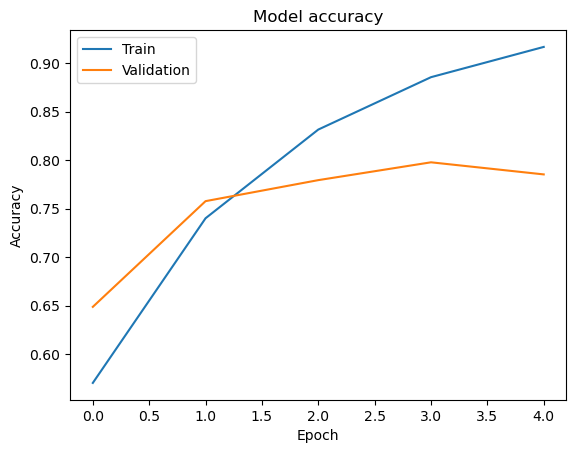

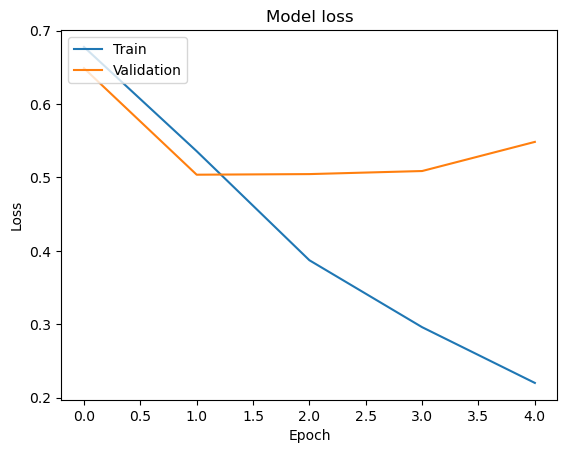

In [44]:
# Evaluate the model
loss_bi, accuracy_bi = model_bi.evaluate(val_padded, y_val)
print('Loss:', loss_bi)
print('Accuracy:', accuracy_bi)

# Plot the training and validation accuracy
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 5. Hyper parameter tuning

To perform hyperparameter tuning for your Bidirectional + Stacked LSTM model, we can explore adjusting several key parameters, including the learning rate, number of LSTM units, dropout rates, and batch size. I'll provide a systematic approach for this.

We can use RandomizedSearchCV with KerasClassifier from scikit-learn, which performs randomized grid search to find the best parameters. Here's a tuning plan for your model:

Learning Rate: Test a range around the current learning rate (e.g., 1e-3, 1e-4, 1e-5).
LSTM Units: Adjust the number of units in each LSTM layer (e.g., 128, 256, 512).
Dropout Rates: Explore variations in dropout rates for each layer (e.g., 0.1, 0.2, 0.3, 0.4).
Dense Layer Units: Vary the units in the dense layer to optimize feature extraction (e.g., 32, 64, 128).
Batch Size: Test different batch sizes for performance tuning (e.g., 32, 64, 128).

In [53]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Define model creation function
def create_model(learning_rate=0.0001, lstm_units=256, dropout_rate=0.3, dense_units=32):
    model = keras.models.Sequential()
    model.add(Embedding(input_dim=num_unique_words, output_dim=32, input_length=max_length))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.1)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.1)))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Custom wrapper for scikit-learn compatibility

class KerasClassifierWrapper:
    def __init__(self, build_fn=create_model, **params):
        self.build_fn = build_fn
        self.params = params
        self.model = None

    def fit(self, X, y, batch_size=64, **fit_params):
        self.model = self.build_fn(**{k: v for k, v in self.params.items() if k != 'batch_size'})
        self.model.fit(X, y, batch_size=self.params.get('batch_size', batch_size), **fit_params)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy

    def get_params(self, deep=True):
        return {'build_fn': self.build_fn, **self.params}

    def set_params(self, **params):
        if 'build_fn' in params:
            self.build_fn = params.pop('build_fn')
        self.params.update(params)
        return self

# Update param_dist without 'batch_size'
param_dist = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'lstm_units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'dense_units': [32, 64, 128]
}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, verbose=1)

# Run the search
random_search_result = random_search.fit(train_padded, y_train, epochs=10, validation_data=(val_padded, y_val), callbacks=[early_stopping], verbose=0)

# Display the best parameters and score
print("Best Parameters: ", random_search_result.best_params_)
print("Best Score: ", random_search_result.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step
64/64 ━━━━━━━━━━

The code below builds and trains an optimized Bidirectional LSTM model for binary classification by leveraging the best hyperparameters identified through RandomizedSearchCV. The selected hyperparameters are retrieved and applied to the model, starting with the embedding layer, followed by two bidirectional LSTM layers and a final LSTM layer with the optimal number of units. The model incorporates dropout regularization with the tuned dropout rate to mitigate overfitting, followed by a dense layer using the optimal number of units and a ReLU activation. The final dense layer uses a sigmoid activation for binary output.



In [60]:
# Retrieve best parameters from the RandomizedSearchCV output
best_params = random_search_result.best_params_

# Build the model using the best parameters
model_bi = keras.models.Sequential()
model_bi.add(Embedding(input_dim=num_unique_words, output_dim=32, input_length=max_length))

# Apply the best LSTM units and dropout rate from the hyperparameter tuning
model_bi.add(Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True, dropout=0.1)))
model_bi.add(Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True, dropout=0.1)))
model_bi.add(LSTM(best_params['lstm_units']))

# Use the best dropout rate in the dropout layer
model_bi.add(Dropout(best_params['dropout_rate']))

# Apply the best dense layer units
model_bi.add(Dense(best_params['dense_units'], activation='relu'))
model_bi.add(Dense(1, activation="sigmoid"))

# Compile the model with the best learning rate
opt = Adam(learning_rate=best_params['learning_rate'])
model_bi.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping and the selected batch size
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_bi = model_bi.fit(train_padded, y_train, epochs=10, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

# Model summary
model_bi.summary()

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.6169 - loss: 0.6277 - val_accuracy: 0.7925 - val_loss: 0.5649
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.8942 - loss: 0.2826 - val_accuracy: 0.7971 - val_loss: 0.4743
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9427 - loss: 0.1834 - val_accuracy: 0.7820 - val_loss: 0.6051
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9651 - loss: 0.1124 - val_accuracy: 0.7643 - val_loss: 0.6542
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9735 - loss: 0.0957 - val_accuracy: 0.7787 - val_loss: 0.5841


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 20, 32)         │       706,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_64                │ (None, 20, 512)        │       591,872 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_65                │ (None, 20, 512)        │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,033,189 (42.09 MB)

 Trainable params: 3,677,729 (14.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,355,460 (28.06 MB)

#### Best parameter model evaluation


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7925 - loss: 0.4805
Baseline Model - Loss: 0.4743422567844391
Baseline Model - Accuracy: 0.7971109747886658


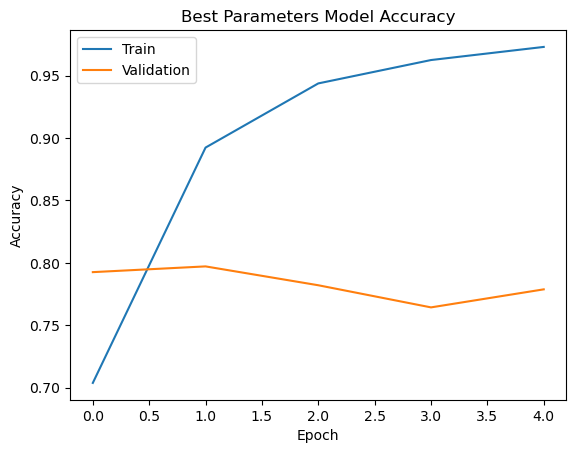

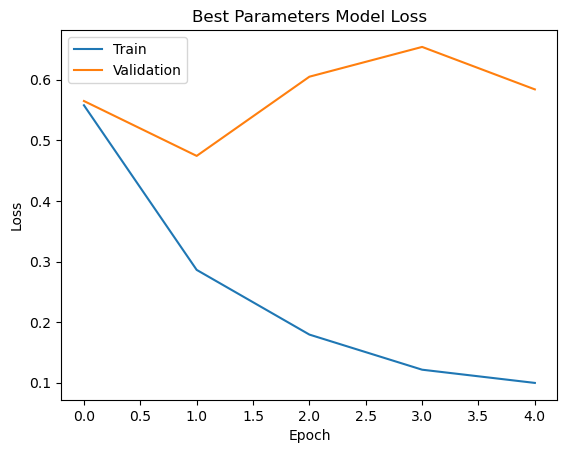

In [64]:
import matplotlib.pyplot as plt

# Baseline Model Evaluation
loss_baseline, accuracy_baseline = model_bi.evaluate(val_padded, y_val)
print('Baseline Model - Loss:', loss_baseline)
print('Baseline Model - Accuracy:', accuracy_baseline)


# Plot the best model's training and validation accuracy
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('Best Parameters Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the best model's training and validation loss
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('Best Parameters Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 6.Conclusion and Submission
In this process, we implemented and optimized a Bidirectional Stacked LSTM model for a binary classification task using a TensorFlow Keras architecture. The model structure included an embedding layer, followed by bidirectional LSTM layers, dropout regularization, and dense layers, with a final sigmoid activation for binary output. To improve performance, we conducted hyperparameter tuning, targeting key parameters such as learning rate, LSTM units, dropout rate, dense layer units, and batch size.

In [66]:
# Preprocess the test data
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(remove_punct)
test_df['text'] = test_df['text'].map(remove_stopwords)

# Convert test data to sequences using the same tokenizer
test_sequences = tokenizer.texts_to_sequences(test_df.text)

# Pad the sequences to have the same length as the training data
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Predict labels for the test data
predictions = model_bi.predict(test_padded)

# Convert probabilities to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Add the predicted labels to the test dataframe
test_df['predicted_label'] = predicted_labels

print(test_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
   id keyword location                                               text  \
0   0     NaN      NaN                   Just happened terrible car crash   
1   2     NaN      NaN  Heard earthquake different cities stay safe ev...   
2   3     NaN      NaN  forest fire spot pond geese fleeing across str...   
3   9     NaN      NaN              Apocalypse lighting Spokane wildfires   
4  11     NaN      NaN             Typhoon Soudelor kills 28 China Taiwan   

   predicted_label  
0                1  
1                1  
2                1  
3                1  
4                1  


In [70]:
submission = pd.DataFrame({
    'id':test_df.id,
    'target':test_df.predicted_label
})

submission.to_csv('submission_rnn_glove.csv', index=False)